# Peptides encoding (One-hot)

In [1]:
import peptides
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

# my module with some func
import pepcode

Fetch all cdr3 sequences from VDJdb ver(vdjdb-2024-11-27-fixed) with `cut -f 2 vdjdb-2024-11-27-fixed/vdjdb.slim.txt | grep -v "cdr3" >cdr3_from_VDJdb.txt`

## Preparing data

Set parameters: 

In [2]:
len_seq = 15
AA_LIST = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

In [3]:
with open("cdr3_from_VDJdb.txt") as file:
    count = 0
    pep_dir = []
    count_dir = 0
    for pep in file:
        pep = pep[:-1]
        count += 1
        if len(pep) == len_seq:
            count_dir +=1
            pep_dir.append(pep)
    print(f'From {count} only {count_dir} with the lengh of {len_seq}')

From 87032 only 18408 with the lengh of 15


In [4]:
pep_oh_encoded = pepcode.one_hot_coding(pep_dir)

In [5]:
print("First peptide (one-hot encoded):\n", pep_oh_encoded[1])
oh_matr_size = pep_oh_encoded[0].size

First peptide (one-hot encoded):
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0

### Split datasets

In [6]:
np.random.shuffle(pep_oh_encoded)
pep_oh_encoded_train = pep_oh_encoded[:int(round(count_dir*0.8, 0))]
pep_oh_encoded_test = pep_oh_encoded[int(round(count_dir*0.8, 0)):]

## Set parameters for ml

In [7]:
latent_dims = 315 # надо посмотреть, что будет с длинной пептида и больше и меньше
num_epochs = 50 
batch_size = int(count_dir/8) # Тут надо быть аккуратней, чтобы делилось на цело
capacity = 64
learning_rate = 1e-3 
use_gpu = True

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Loading datasets

In [8]:
#oh_dataset = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded), torch.tensor(np.ones(count_dir)))
#oh_encoded_dl = torch.utils.data.DataLoader(oh_dataset, batch_size=batch_size, shuffle=True)

# Train dataset
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded_train), torch.tensor(np.ones(int(round(count_dir*0.8, 0)))))
oh_encoded_dl_train = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=True)

# Test dataset
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_oh_encoded_test), torch.tensor(np.ones(count_dir - int(round(count_dir*0.8, 0)))))
oh_encoded_dl_test = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=True)

## Autoencoder_1SM definition (1 layer, Sigmoid, MSE loss)

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=latent_dims)
            
    def forward(self, x):
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1sm = Autoencoder()

autoencoder_1sm = autoencoder_1sm.to(device)

num_params = sum(p.numel() for p in autoencoder_1sm.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1sm.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 199080


### Train autoencoder

In [10]:
# set to training mode
autoencoder_1sm.train()

train_loss_avg_1sm = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1sm.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_encoded_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sm(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1sm[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1sm[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1sm[-1]))
print('Train finished')

Training ...
Epoch [1 / 50] average reconstruction error: 0.227475
Epoch [2 / 50] average reconstruction error: 0.142536
Epoch [3 / 50] average reconstruction error: 0.058565
Epoch [4 / 50] average reconstruction error: 0.033752
Epoch [5 / 50] average reconstruction error: 0.031163
Epoch [6 / 50] average reconstruction error: 0.030619
Epoch [7 / 50] average reconstruction error: 0.030169
Epoch [8 / 50] average reconstruction error: 0.029659
Epoch [9 / 50] average reconstruction error: 0.029125
Epoch [10 / 50] average reconstruction error: 0.028542
Epoch [11 / 50] average reconstruction error: 0.028031
Epoch [12 / 50] average reconstruction error: 0.027496
Epoch [13 / 50] average reconstruction error: 0.026987
Epoch [14 / 50] average reconstruction error: 0.026489
Epoch [15 / 50] average reconstruction error: 0.026031
Epoch [16 / 50] average reconstruction error: 0.025563
Epoch [17 / 50] average reconstruction error: 0.025136
Epoch [18 / 50] average reconstruction error: 0.024654
Epoch 

### Evaluation

In [11]:
# set to evaluation mode
autoencoder_1sm.eval()
counter = 0

test_loss_avg_1sm, num_batches = 0, 0
for pep_batch, _ in oh_encoded_dl_test:
    
    with torch.no_grad():

        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)

        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sm(pep_batch)

        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)

        if counter == 0:
            eval_bef_1sm = pep_batch[0].reshape(len(AA_LIST), len_seq)
            eval_err_1sm = loss.item()
            eval_aft_1sm = pep_batch_recon[0].reshape(len(AA_LIST), len_seq)
            counter +=1

        test_loss_avg_1sm += loss.item()
        num_batches += 1
        
    
test_loss_avg_1sm /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1sm))

Average reconstruction error: 0.013097


## Autoencoder_1SB definition (1 layer, Sigmoid, BCE loss)

In [12]:
autoencoder_1sb = Autoencoder()

autoencoder_1sb = autoencoder_1sb.to(device)

num_params = sum(p.numel() for p in autoencoder_1sb.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(autoencoder_1sb.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters: 199080


### Train autoencoder

In [13]:
autoencoder_1sb.train()

train_loss_avg_1sb = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1sb.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_encoded_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sb(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1sb[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1sb[-1] /= num_batches
    #print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
print('Train finished')

Training ...
Train finished


### Evaluation

In [14]:
# set to evaluation mode
autoencoder_1sb.eval()
counter = 0

test_loss_avg_1sb, num_batches = 0, 0
for pep_batch, _ in oh_encoded_dl_test:
    
    with torch.no_grad():

        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)

        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1sb(pep_batch)

        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)

        if counter == 0:
            eval_bef_1sb = pep_batch[0].reshape(len(AA_LIST), len_seq)
            eval_err_1sb = loss.item()
            eval_aft_1sb = torch.round(pep_batch_recon[0].reshape(len(AA_LIST), len_seq))
            counter +=1

        test_loss_avg_1sb += loss.item()
        num_batches += 1
        
    
test_loss_avg_1sb /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1sb))

Average reconstruction error: 0.040772


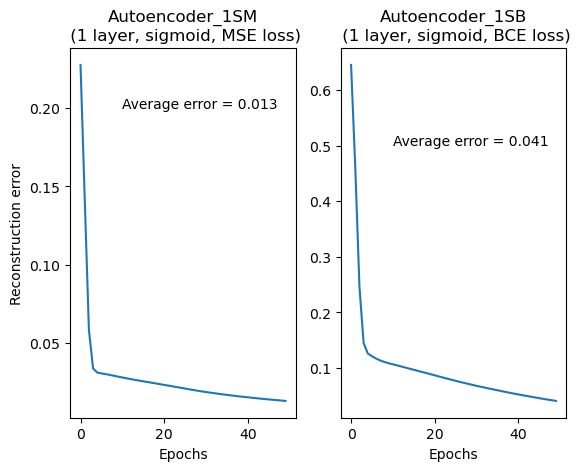

In [15]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(train_loss_avg_1sm)
ax[0].set_title("Autoencoder_1SM\n (1 layer, sigmoid, MSE loss)")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Reconstruction error')
ax[0].text(10,0.2, F"Average error = {round(test_loss_avg_1sm, 3)}")

ax[1].plot(train_loss_avg_1sb)
ax[1].set_title("Autoencoder_1SB\n (1 layer, sigmoid, BCE loss)")
ax[1].set_xlabel('Epochs')
ax[1].text(10,0.5, F"Average error = {round(test_loss_avg_1sb, 3)}")


plt.show()
fig.savefig(F"{str(date.today())}_One_hot_lat_dim={latent_dims}")

In [16]:
raw_eval_aft_1sm = eval_aft_1sm.numpy(force=True)

In [17]:
raw_eval_aft_1sm_old = np.copy(raw_eval_aft_1sm)
for i in range(len_seq):
    col_max = np.max(raw_eval_aft_1sm[:,i])
    for j in range(len(AA_LIST)):
        if raw_eval_aft_1sm[j][i] == col_max:
            raw_eval_aft_1sm[j][i] = 1.0
        else: raw_eval_aft_1sm[j][i] = 0.0  

In [18]:
print("Peptide:", pepcode.one_hot_decoding(eval_bef_1sm.numpy(force=True)))
print("Before autoencoder:\n", eval_bef_1sm.numpy(force=True))
print("After autoencoder:\n", raw_eval_aft_1sm)  
print("Peptide:", pepcode.one_hot_decoding(raw_eval_aft_1sm))

Peptide: CAESIPAGANSKLTF
Before autoencoder:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0